In [45]:
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import numpy as np
import requests
from toolz import pipe, flip, partial, curry

def load(url):
    return pipe(
        url,
        requests.get,
        flip(getattr, 'content'),
        bytearray,
        partial(np.asarray, dtype='uint8'),
        flip(cv2.imdecode, cv2.IMREAD_COLOR)
    )

original_image = load('https://api.mapbox.com/v4/mapbox.satellite/17/36850/51628@2x.png?access_token=<sample token>')
image = cv2.imread('./tests/fixtures/sample.jpg') / 255

In [46]:
@curry
def drawn_contours(original, predicted_mask, tolerance):
    # Use threshold and find contours
    _, threshold = cv2.threshold(predicted_mask, 1 - tolerance, 1, cv2.THRESH_BINARY)
    gray = cv2.cvtColor(np.array(threshold, np.uint8), cv2.COLOR_BGR2GRAY)
    _, contours, hierarchy = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours
    marked = original.copy()
    cv2.drawContours(marked, contours, -1, (255,0,0), 3)
    return marked

In [52]:
from moviepy.editor import ImageSequenceClip

tolerances = map(lambda x: 1 - (x / 20), range(19))

contour_images = list(map(drawn_contours(original_image, image), tolerances))
clip = ImageSequenceClip(contour_images, fps=3)
clip.write_gif('./tests/fixtures/contour_animation.gif', fps=3, loop=True)


t:  16%|█▌        | 3/19 [00:00<00:00, 16.26it/s, now=None]

MoviePy - Building file ./tests/fixtures/contour_animation.gif with imageio.


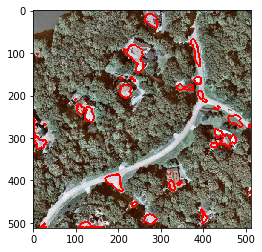

In [36]:
plt.imshow(drawn_contours(original_image, image, 0.5))
plt.show()